# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


Done by :

* BENHADDAD Sabrina - Group 3 - DAC

* BENSIDHOUM Azzedine - Group 3 - DAC

Avant de commencer le TP, vérifiez que vous êtes sur un environnement GPU et python 3 :

Exécution -> Modifier le type d'exécution -> Type d'exécution = python2, Accélerateur matériel = GPU

In [1]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

# Partie 1 : Architecture VGG16

#### Bonus - Question 3 : Apply the network on several images

In this section, we will conduct an extensive evaluation of our network using a diverse selection of images, each varying in complexity. Our objective is to thoroughly explore and gain insights into the capabilities and performance of the pre-trained VGG16 model. For this purpose, we have chosen a range of images including the standard cat and dog, as well as more diverse subjects such as a car, a kiwi, and a fox. Additionally, we will challenge the model with a complex image of a human. This varied selection is intended to provide a comprehensive understanding of how the VGG16 model responds to different types of visual data, ranging from simple to intricate.

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

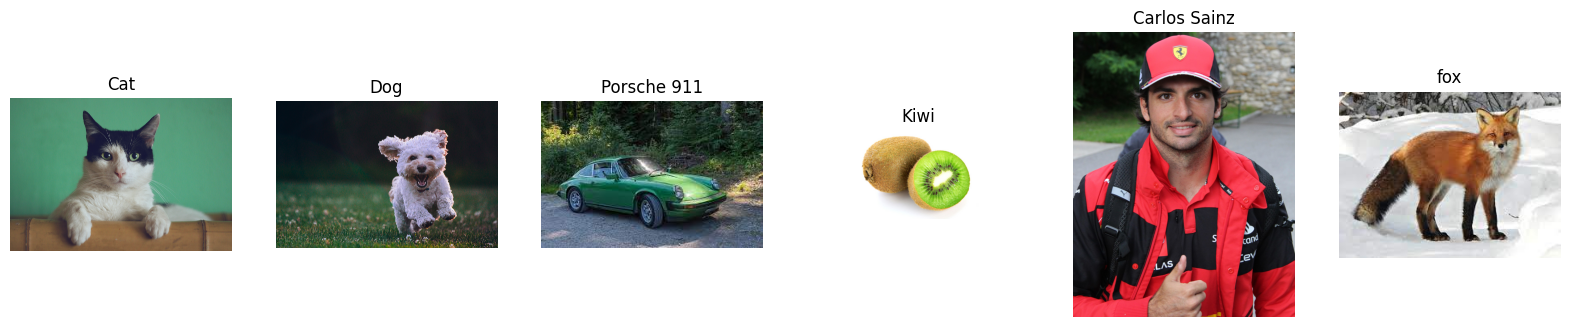

In [ ]:
cat = Image.open('cat.jpg')
dog = Image.open('dog.jpg')
porsche911 = Image.open('porsche911.jpeg')
kiwi = Image.open('kiwi.jpeg')
carlossainz = Image.open('carlos_sainz.jpeg')
fox = Image.open('fox.jpeg')


fig, axes = plt.subplots(1, 6, figsize=(20, 4))


axes[0].imshow(cat)
axes[0].set_title('Cat')
axes[0].axis('off')  # To disable the axes

axes[1].imshow(dog)
axes[1].set_title('Dog')
axes[1].axis('off')

axes[2].imshow(porsche911)
axes[2].set_title('Porsche 911')
axes[2].axis('off')

axes[3].imshow(kiwi)
axes[3].set_title('Kiwi')
axes[3].axis('off')

axes[4].imshow(carlossainz)
axes[4].set_title('Carlos Sainz')
axes[4].axis('off')

axes[5].imshow(fox)
axes[5].set_title('fox')
axes[5].axis('off')


plt.show()


In [ ]:
# VOTRE CODE ICI pour le bonus:

vgg16 = torchvision.models.vgg16(pretrained=True)

imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))
images = ['cat.jpg', 'dog.jpg', 'porsche911.jpeg', 'kiwi.jpeg', 'carlos_sainz.jpeg','fox.jpeg']

In [ ]:
def classify_image(image_path, model, classes):

  img = Image.open(image_path)

  #preprocessing of our image
  our_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])])

  x = our_transform(img)
  x = torch.unsqueeze(x, 0)
  model.eval()

  #To avoid the computation of the gradients
  with torch.no_grad():
    y = model(x)

  #We use Softmax in order to have the probabilities of the predictions
  probabilities = torch.nn.functional.softmax(y, dim = 1)

  #Obtain the predicted class and its probability
  yhat = probabilities.argmax(dim=1).item()
  predicted_probability = probabilities[0, yhat].item()

  return classes[yhat], predicted_probability

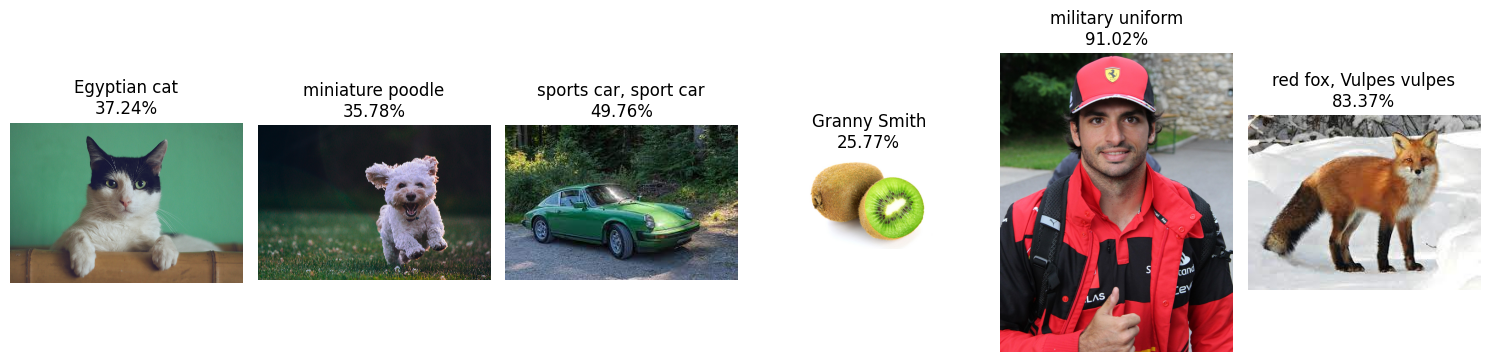

In [ ]:
# Display and save images with predictions
fig, axs = plt.subplots(1, len(images), figsize=(15, 5))

for i, image in enumerate(images):
    predicted_class, proba = classify_image(image, vgg16, imagenet_classes)

    axs[i].imshow(plt.imread(image))
    axs[i].axis('off')
    axs[i].set_title(f"{predicted_class}\n{round(proba*100,2)}%")

plt.tight_layout()
plt.savefig('classified_images.png')  # Saving the figure
plt.show()

#### Bonus - Question 4 : Visualize several activation maps obtained after the first convolutional layer

In [ ]:
def viz_activation_maps(image_path, model, classes):

  img = Image.open(image_path)

  #preprocessing of our image
  our_transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])])

  x = our_transform(img)
  x = torch.unsqueeze(x, 0)

  #We first modify the model to extract features from the first convolutional layer
  first_two_layers = model.features[:2]

  #To avoid the computation of the gradients
  with torch.no_grad():
    activation_maps = first_two_layers(x)

  # Get the number of activation maps and ensure we only plot the first 4
    num_maps = min(activation_maps.shape[1], 4)

  # Plot the activation maps
  fig, axes = plt.subplots(1, num_maps, figsize=(num_maps * 2, 2))
  for i in range(num_maps):
      axes[i].imshow(activation_maps[0, i].cpu().numpy(), cmap='gray')
      axes[i].axis('off')
  plt.show()


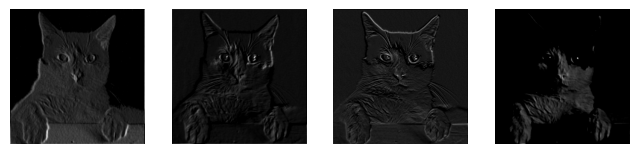

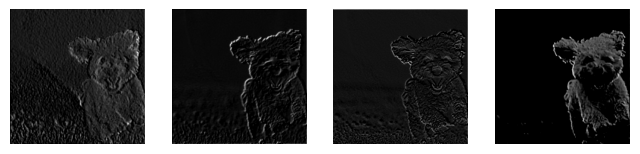

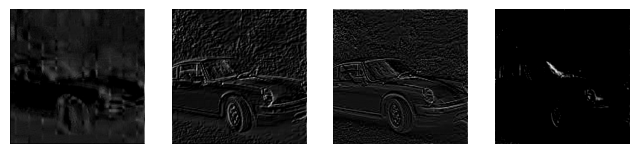

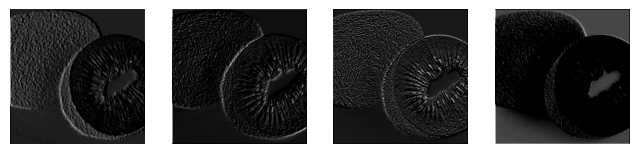

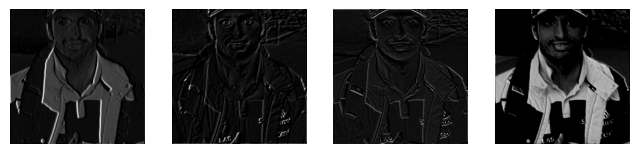

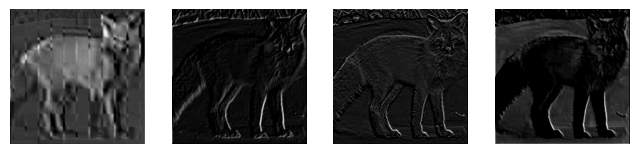

In [ ]:
for image in images:
  viz_activation_maps(image, vgg16, imagenet_classes)

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

In [ ]:
ls 15SceneData/test/bedroom/

#### 2.2 Feature Extraction with VGG16

In [6]:
class VGG16_modified(nn.Module):
  def __init__(self, layer):
    super(VGG16_modified, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg16.features.children()))
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:layer+1])
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [7]:

PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    #####################
    ## Votre code ici  ##
    #####################
    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',
    transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.Lambda(duplicateChannel),
        transforms.ToTensor(),  # Convertit l'image PIL en Tensor
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])  # Normalise le Tensor
        ])
    )

    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Lambda(duplicateChannel),
            transforms.ToTensor(),  # Convertit l'image PIL en Tensor
            transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                std = [0.229, 0.224, 0.225])  # Normalise le Tensor
        ])
    )

    ####################
    ##      FIN        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [8]:
def extract_features(data, model):
    #####################
    ## Votre code ici  ##
    #####################
    # init features matrices
    device = torch.device("cuda" if CUDA else "cpu")
    X = torch.tensor([], device = device)
    y = torch.tensor([])
    ####################
    ##      FIN        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.to(device)
        #####################
        ## Votre code ici  ##
        #####################
        # Feature extraction à faire
        X = torch.cat((X,model(input)))
        y = torch.cat((y,target))
        ####################
        ##      FIN        #
        ####################

    return X, y

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:50'

def main(path="15SceneData", batch_size=8,layer = -3):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16 modifié')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = VGG16_modified(layer)
    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    with torch.no_grad():
      X_train, y_train = extract_features(train, model)
      X_test, y_test = extract_features(test, model)

    return X_train.cpu().numpy(),X_test.cpu().numpy(), y_train.cpu().numpy(), y_test.cpu().numpy()

In [9]:
X_train, X_test, y_train, y_test = main("15SceneData", 8,-3)

Instanciation de VGG16
Instanciation de VGG16 modifié
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374


#### 2.3 Training SVM classifiers

In [42]:
#####################
## Votre code ici  ##
#####################
# Apprentissage et évaluation des SVM à faire
print('Apprentissage des SVM')
accuracy = 0

#According to the pdf file provided, we train an SVM on the training set
#With C = 1

svm = LinearSVC(C=1.0).fit(X_train, y_train)
y_hat = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_hat)
####################
##      FIN        #
####################
print(f"Accuracy = {round(accuracy*100,2)} %")

Apprentissage des SVM
Accuracy = 88.58 %


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### 2.4 Going further

* Trying other available pre-trained networks

To initiate our experiments, we will utilize alternative pre-trained networks and assess their performance. In addition to VGG16, we will evaluate the AlexNet, network.

In [52]:
def evaluate_models(path="15SceneData", batch_size=8, layer=-3):
    models_to_evaluate = ['VGG16_modified', 'AlexNet']
    model_performances = {}

    for model_name in models_to_evaluate:
        print(f'Model :  {model_name}')
        if model_name == 'VGG16_modified':
            model = VGG16_modified(layer)
        elif model_name == 'AlexNet':
            model = models.alexnet(pretrained=True)

        if CUDA:
            model = model.cuda()

        print('Data : ')
        train, test = get_dataset(batch_size, path)

        print('Feature extraction')
        with torch.no_grad():
            X_train, y_train = extract_features(train, model)
            X_test, y_test = extract_features(test, model)

        print('SVM')
        svm = LinearSVC(C=1.0).fit(X_train.cpu().numpy(), y_train.cpu().numpy())
        y_hat = svm.predict(X_test.cpu().numpy())
        accuracy = accuracy_score(y_test.cpu().numpy(), y_hat)
        model_performances[model_name] = accuracy

    for model_name, accuracy in model_performances.items():
        print(f"Accuracy for {model_name} = {round(accuracy * 100, 2)} %")


In [53]:
# Call the main function
evaluate_models("15SceneData", 8, -3)

Model :  VGG16_modified
Data : 
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model :  AlexNet
Data : 
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Accuracy for VGG16_modified = 88.58 %
Accuracy for AlexNet = 80.0 %


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


* Change the layer at which the features are extracted

To achieve this goal, we have slightly modified the `vgg16relu7` class, renaming it to `vgg16_modified`. This updated class takes a parameter `layer`, which specifies the particular layer at which the features will be extracted.

In [60]:
layers_test = [2,4,6,10]
performances = []

for layer in layers_test :
  X_train, X_test, y_train, y_test = main("15SceneData", 8,layer)
  svm = LinearSVC(C=1.0).fit(X_train, y_train)
  y_hat = svm.predict(X_test)
  performances.append(accuracy_score(y_test, y_hat))


Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16 modifié
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16
Instanciation de VGG16 modifié
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16
Instanciation de VGG16 modifié
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16
Instanciation de VGG16 modifié
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


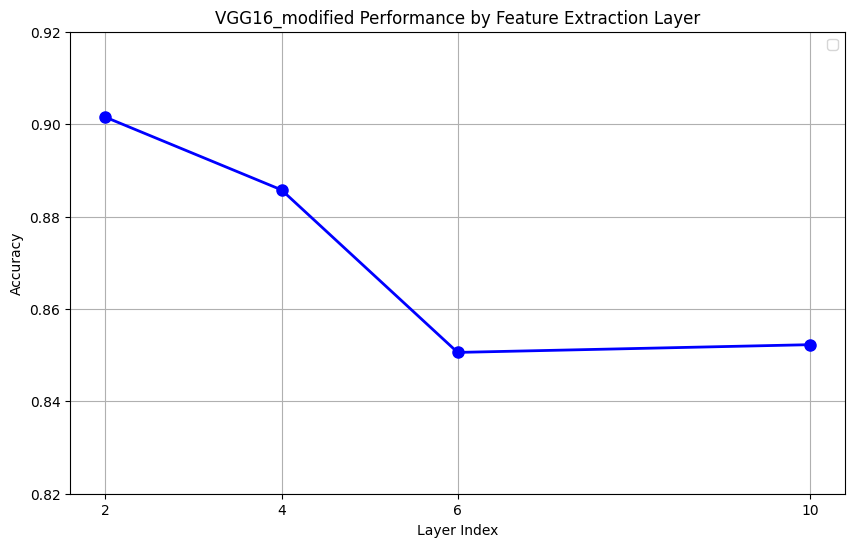

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(layers_test, performances, 'o-', color='blue', linewidth=2, markersize=8)

plt.xlabel('Layer Index')
plt.ylabel('Accuracy')
plt.title('VGG16_modified Performance by Feature Extraction Layer')
plt.legend()
plt.grid(True)
plt.xticks(layers_test)
plt.yticks(np.arange(0.82, 0.92, 0.02))
plt.savefig('change_layers.png')
plt.show()

- Tune the parameter C to improve performance

In [67]:
def evaluate_models(model_name, C, path="15SceneData", batch_size=8, layer=-3):
    print(f'Evaluating {model_name} with C={C}')
    model_performance = {}

    if model_name == 'vgg16':
        model = VGG16_modified(layer)
    elif model_name == 'alexnet':
        model = models.alexnet(pretrained=True)
    if CUDA:
        model = model.cuda()

    print('Data : ')
    train, test = get_dataset(batch_size, path)

    print('Feature extraction')
    with torch.no_grad():
        X_train, y_train = extract_features(train, model)
        X_test, y_test = extract_features(test, model)

    print('SVM')
    svm = LinearSVC(C=C).fit(X_train.cpu().numpy(), y_train.cpu().numpy())
    y_hat = svm.predict(X_test.cpu().numpy())
    accuracy = accuracy_score(y_test.cpu().numpy(), y_hat)

    return accuracy

In [68]:
Cs = [1e-5, 1e-3, 1e-2, 1e-1, 1, 10, 100]
models_to_test = ['vgg16', 'alexnet']
performances = {model: [] for model in models_to_test}

for C in Cs:
    for model_name in models_to_test:
        accuracy = evaluate_models(model_name, C)
        performances[model_name].append(accuracy)


Evaluating vgg16 with C=1e-05
Data : 
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Evaluating alexnet with C=1e-05


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Data : 
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Evaluating vgg16 with C=0.001
Data : 
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Evaluating alexnet with C=0.001


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Data : 
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Evaluating vgg16 with C=0.01
Data : 
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Evaluating alexnet with C=0.01


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Data : 
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Evaluating vgg16 with C=0.1
Data : 
Feature extraction


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Evaluating alexnet with C=0.1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Data : 
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Evaluating vgg16 with C=1
Data : 
Feature extraction


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating alexnet with C=1
Data : 
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Evaluating vgg16 with C=10
Data : 
Feature extraction


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Evaluating alexnet with C=10


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Data : 
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Evaluating vgg16 with C=100
Data : 
Feature extraction


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM
Evaluating alexnet with C=100


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Data : 
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
SVM


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


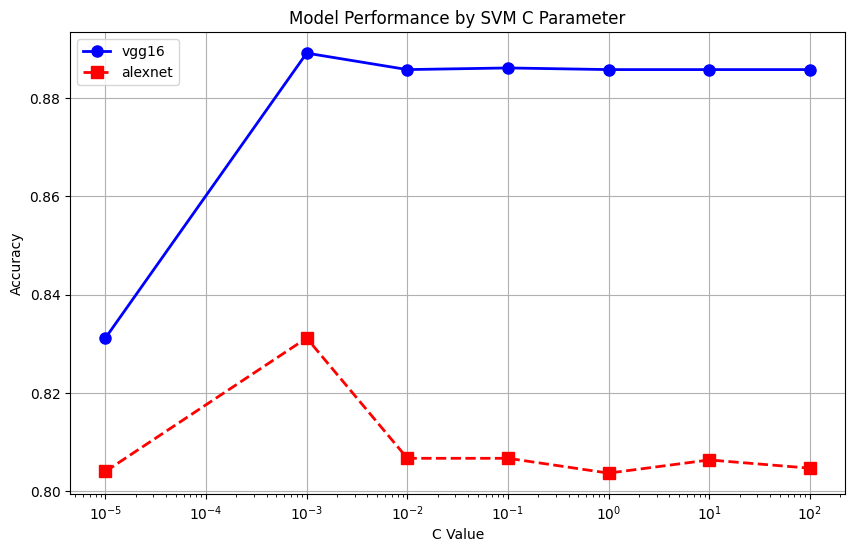

In [69]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot the performance for each model
for model_name, acc in performances.items():
    if model_name == 'vgg16':
        plt.plot(Cs, acc, 'o-', color='blue', label='vgg16', linewidth=2, markersize=8)
    elif model_name == 'alexnet':
        plt.plot(Cs, acc, 's--', color='red', label='alexnet', linewidth=2, markersize=8)

# Customize the plot to match the style of the image
plt.xscale('log')  # Since we're using a logarithmic scale for C
plt.xlabel('C Value')
plt.ylabel('Accuracy')
plt.title('Model Performance by SVM C Parameter')
plt.legend()
plt.grid(True)

# Save the plot as a PNG file
plt.savefig('svm_c_tuning.png')

# Show the plot
plt.show()

In [70]:
param_grid = {
    'C': [1e-5,1e-3, 1e-2, 1e-1, 1,10,100]
}
grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...........................C=1e-05;, score=0.837 total time=   0.4s
[CV 2/5] END ...........................C=1e-05;, score=0.837 total time=   0.4s
[CV 3/5] END ...........................C=1e-05;, score=0.840 total time=   0.4s
[CV 4/5] END ...........................C=1e-05;, score=0.797 total time=   0.6s
[CV 5/5] END ...........................C=1e-05;, score=0.840 total time=   0.4s
[CV 1/5] END ...........................C=0.001;, score=0.857 total time=   1.5s
[CV 2/5] END ...........................C=0.001;, score=0.837 total time=   1.4s
[CV 3/5] END ...........................C=0.001;, score=0.863 total time=   1.1s
[CV 4/5] END ...........................C=0.001;, score=0.843 total time=   1.1s
[CV 5/5] END ...........................C=0.001;, score=0.893 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ............................C=0.01;, score=0.837 total time=   3.6s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ............................C=0.01;, score=0.823 total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ............................C=0.01;, score=0.883 total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ............................C=0.01;, score=0.843 total time=   3.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ............................C=0.01;, score=0.880 total time=   3.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END .............................C=0.1;, score=0.803 total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END .............................C=0.1;, score=0.807 total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .............................C=0.1;, score=0.863 total time=   3.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END .............................C=0.1;, score=0.840 total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .............................C=0.1;, score=0.863 total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ...............................C=1;, score=0.803 total time=   3.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ...............................C=1;, score=0.810 total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ...............................C=1;, score=0.857 total time=   4.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ...............................C=1;, score=0.837 total time=   3.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ...............................C=1;, score=0.863 total time=   3.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END ..............................C=10;, score=0.807 total time=   6.8s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END ..............................C=10;, score=0.820 total time=   5.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..............................C=10;, score=0.853 total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END ..............................C=10;, score=0.837 total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END ..............................C=10;, score=0.863 total time=   3.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/5] END .............................C=100;, score=0.810 total time=   3.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END .............................C=100;, score=0.820 total time=   3.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .............................C=100;, score=0.853 total time=   4.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END .............................C=100;, score=0.833 total time=   3.3s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .............................C=100;, score=0.860 total time=   3.4s


GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [1e-05, 0.001, 0.01, 0.1, 1, 10, 100]},
             verbose=3)

In [71]:
print(f"Best C : {grid.best_params_}")

grid_predictions = grid.predict(X_test)

print(f"Accracy score {round(accuracy_score(y_test, grid_predictions)*100,2)}%")

Best C : {'C': 0.001}
Accracy score 87.34%


* Dimensionality reduction - PCA

In [10]:
# Initial parameters
pca_components_list = [50, 100, 150, 200, 256]  # PCA components to test
accuracies = []
execution_times = []

# Loop over PCA components
for n_components in pca_components_list:
    start_time = time.time()

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train and evaluate SVM
    svm = LinearSVC(C=1.0)
    svm.fit(X_train_pca, y_train)
    predictions = svm.predict(X_test_pca)

    # Record accuracy and execution time
    accuracies.append(accuracy_score(y_test, predictions))
    execution_times.append(time.time() - start_time)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


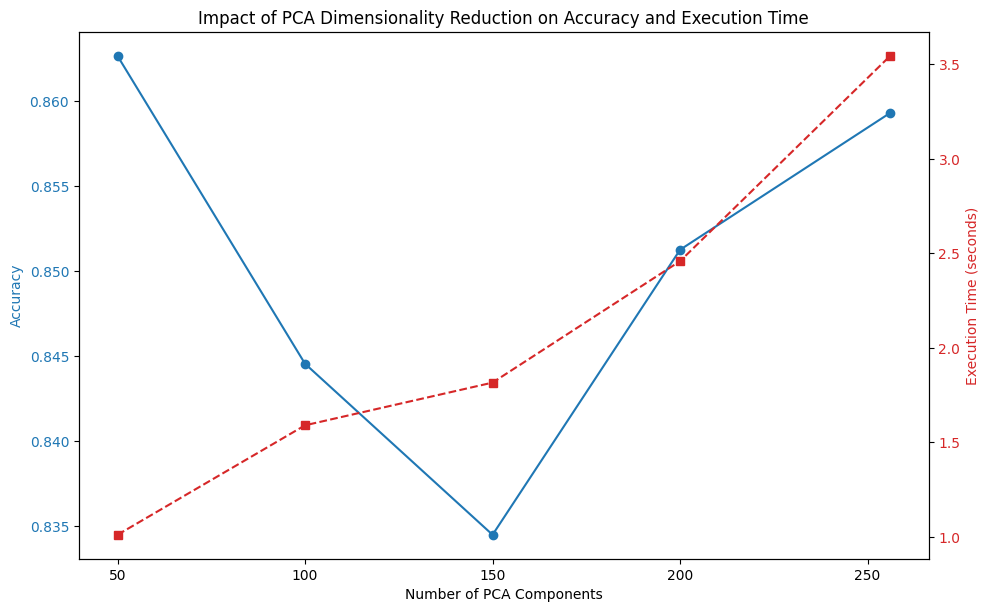

In [11]:
# Create the plot with two different y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Number of PCA Components')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(pca_components_list, accuracies, 'o-', color=color, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Execution Time (seconds)', color=color)
ax2.plot(pca_components_list, execution_times, 's--', color=color, label='Execution Time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # To adjust plot to prevent label cutoff
plt.title('Impact of PCA Dimensionality Reduction on Accuracy and Execution Time')
plt.savefig('pca.png')
plt.show()